<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-&amp;-Variables" data-toc-modified-id="Imports-&amp;-Variables-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports &amp; Variables</a></span><ul class="toc-item"><li><span><a href="#Colab" data-toc-modified-id="Colab-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Colab</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Variables" data-toc-modified-id="Variables-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Variables</a></span></li></ul></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Model-architecture" data-toc-modified-id="Model-architecture-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Model architecture</a></span></li><li><span><a href="#Loss,-Optimizer,-Metrics" data-toc-modified-id="Loss,-Optimizer,-Metrics-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Loss, Optimizer, Metrics</a></span></li><li><span><a href="#Model-training" data-toc-modified-id="Model-training-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Model training</a></span></li><li><span><a href="#Model-evaluation" data-toc-modified-id="Model-evaluation-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Model evaluation</a></span></li><li><span><a href="#Model-evaluation" data-toc-modified-id="Model-evaluation-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Model evaluation</a></span><ul class="toc-item"><li><span><a href="#Get-predictions" data-toc-modified-id="Get-predictions-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>Get predictions</a></span></li><li><span><a href="#Evaluate-test-split" data-toc-modified-id="Evaluate-test-split-3.5.2"><span class="toc-item-num">3.5.2&nbsp;&nbsp;</span>Evaluate test split</a></span><ul class="toc-item"><li><span><a href="#F1-Report" data-toc-modified-id="F1-Report-3.5.2.1"><span class="toc-item-num">3.5.2.1&nbsp;&nbsp;</span>F1 Report</a></span></li><li><span><a href="#Confusion-Matrix" data-toc-modified-id="Confusion-Matrix-3.5.2.2"><span class="toc-item-num">3.5.2.2&nbsp;&nbsp;</span>Confusion Matrix</a></span></li></ul></li></ul></li></ul></li></ul></div>

This notebook is used for the training of our model and its evaluation on the test split. 

# Imports & Variables

## Colab

In [1]:
from termcolor import colored

try:
    from google.colab import drive
    COLAB = True
    print('Running the notebook on',colored('Colab','yellow'))
except:
    COLAB = False
    print('Running the notebook on',colored('your machine','blue'))

Running the notebook on your machine


## Imports

In [2]:
## utilities
import os 
import pickle
from datetime import datetime

## classics 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

## deep
import tensorflow as tf

if COLAB:
    !pip install --quiet transformers

from transformers import AutoTokenizer, TFAutoModel, AutoConfig

In [3]:
#evaluation metrics
from sklearn.metrics import confusion_matrix

## Variables

In [4]:
#Max len of essay 
SEQ_LEN = 1024 ## THIS SHOULD NOT BE CHANGED without appropriate changes in the preprocessing 

#Train, val, test split proportion
VAL_SPLIT = 0.8
TEST_SPLIT = 0.9

#Batch size
BATCH_SIZE = 16

#Data version
VERSION=3

# Load weights of trained model
MODEL_NAME = 'mymodel'
LOAD_MODEL = True
LOAD_BACKBONE_FROM = '/content/drive/MyDrive/feedback-prize/backbone'
LOAD_MODEL_WEIGHTS_FROM = '/content/drive/MyDrive/feedback-prize/mymodel/mymodel'

In [5]:
## Paths

## if running in colab, mount drive
if COLAB:
    drive.mount('/content/drive')
    PATH='/content/drive/MyDrive/feedback-prize/'
else:
    PATH='../'

# Load data

The data is already preprocessed in another notebook.

The preprocessed data is loaded and splitted in `train`, `val`, `test`

In [6]:
#Load train and test data
with open(os.path.join(PATH,'raw_data',f'dataset_v{VERSION}.pickle'),'rb') as file:
    dataset = pickle.load(file)
    
with open(os.path.join(PATH,'raw_data',f'dataset_test_v{VERSION}.pickle'),'rb') as file:
    dataset_inf = pickle.load(file)

In [7]:
#Load preprocessed.csv file as it will be needed to retrieve predictions
df_essays = pd.read_csv(os.path.join(PATH,'raw_data',f'preprocessed_v{VERSION}.csv'))
df_inf = pd.read_csv(os.path.join(PATH,'raw_data',f'preprocessed_inf_v{VERSION}.csv'),index_col=0)

In [8]:
## Creating splits indexes

LEN=len(dataset['labels'])

idx_val=int(LEN*VAL_SPLIT)
idx_test=int(LEN*TEST_SPLIT)

idx_train=list(range(0,idx_val))
idx_val=list(range(idx_val,idx_test))
idx_test=list(range(idx_test,LEN))

assert(len(idx_test)+len(idx_train)+len(idx_val)==LEN)

In [9]:
## Splitting dataset

#train
X_train = {
    'input_ids' : dataset['inputs']['input_ids'][idx_train],
    'attention_mask' : dataset['inputs']['attention_mask'][idx_train]
}

y_train = dataset['labels'][idx_train]
ps_train = dataset['predictionstrings'][idx_train]

#val
X_val = {
    'input_ids' : dataset['inputs']['input_ids'][idx_val],
    'attention_mask' : dataset['inputs']['attention_mask'][idx_val]
}

y_val = dataset['labels'][idx_val]
ps_val = dataset['predictionstrings'][idx_val]


#test
X_test = {
    'input_ids' : dataset['inputs']['input_ids'][idx_test],
    'attention_mask' : dataset['inputs']['attention_mask'][idx_test]
}

y_test = dataset['labels'][idx_test]
ps_test = dataset['predictionstrings'][idx_test]

#inference
X_inf = dataset_inf['inputs']
ps_inf = dataset_inf['predictionstrings']

# Modeling

## Model architecture

In [14]:
## Instantiate model Longformer to be used as backbone
config = AutoConfig.from_pretrained(os.path.join(LOAD_BACKBONE_FROM,'config.json'))
backbone = TFAutoModel.from_pretrained(os.path.join(LOAD_BACKBONE_FROM,'tf_model.h5'),config=config)

All model checkpoint layers were used when initializing TFLongformerModel.

All the layers of TFLongformerModel were initialized from the model checkpoint at /content/drive/MyDrive/feedback-prize/backbone/tf_model.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLongformerModel for predictions without further training.


In [15]:
## TODO : retrieve the attention mask from backbone and pass it to the two LSTM ; currently highly possible the attention mask got lost

# init model

def init_model():
    input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,),dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(SEQ_LEN,),dtype='int32')
    
    x = backbone({'input_ids':input_ids,
                 'attention_mask':attention_mask})[0]

    backbone.trainable = False


    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 512,
                                                           activation = 'tanh',
                                                           dropout=.2,
                                                           return_sequences=True))(x)
    x_res = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 512,
                                                           activation = 'tanh',
                                                           dropout=.2,
                                                           return_sequences=True))(x)
    

    x = tf.keras.layers.add([x,x_res])
    output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16,activation = 'softmax'))(x)

    model = tf.keras.models.Model(inputs={'input_ids':input_ids,
                                          'attention_mask':attention_mask},outputs=output)
    
    
    return model

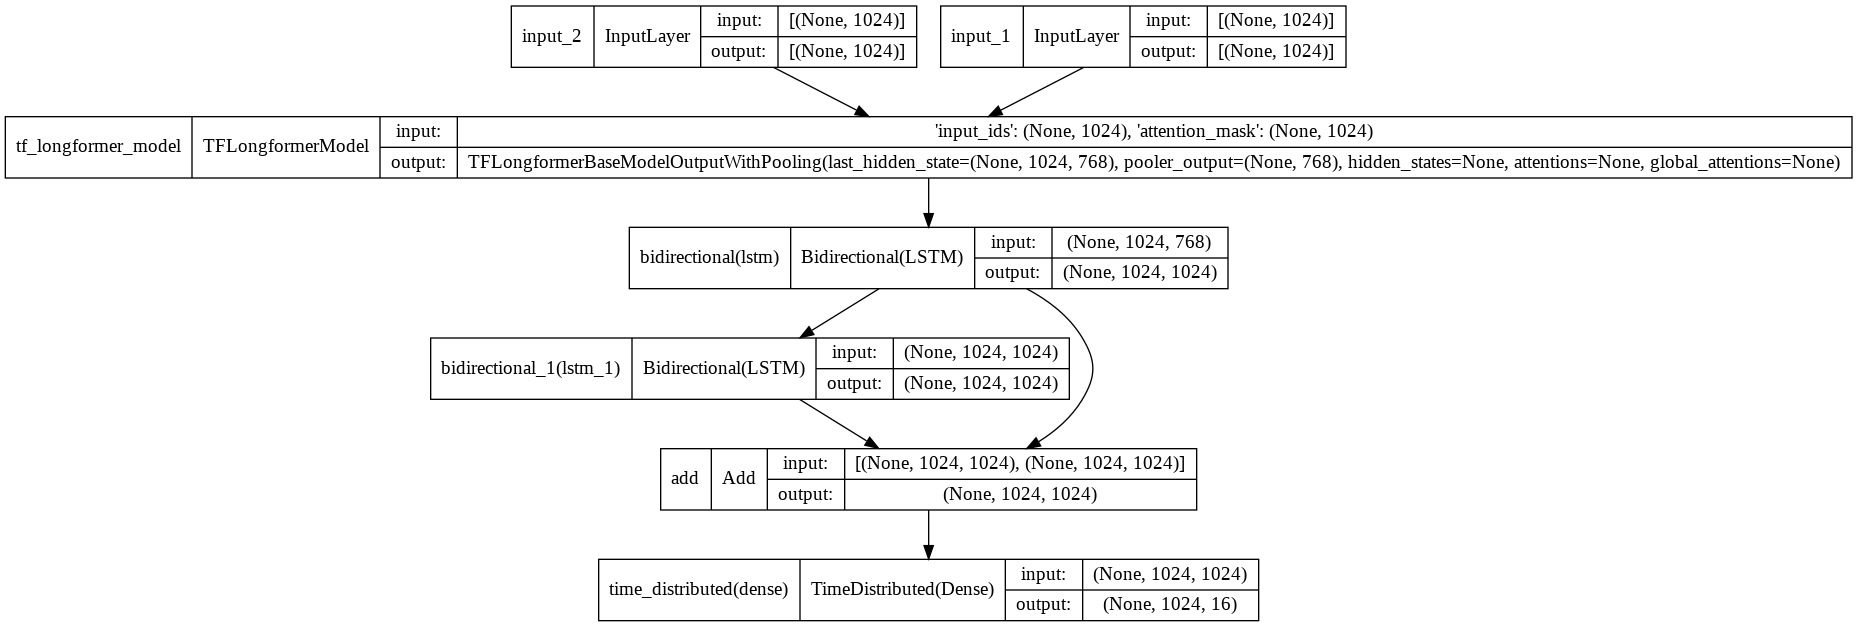

In [16]:
## instantiate the model, plot the graph
model = init_model()

tf.keras.utils.plot_model(model,show_shapes=True)

## Loss, Optimizer, Metrics

In [17]:
# creating homemade metric

def accuracy_masked_func(y_true,y_pred):
    y_pred = tf.cast(tf.argmax(y_pred,axis=-1),'int32')
    y_true = tf.cast(y_true,'int32')
    y_true = tf.cast(tf.argmax(y_true,axis=-1),'int32') #for y_pred and y_true to match
    mask = tf.cast(y_true != 15,'int32') #create a mask
    matches = tf.cast(tf.equal(y_true,y_pred),'int32')*mask #calculate the matches ignoring the masking
    accuracy = tf.math.reduce_sum(matches,axis=-1)/tf.maximum(tf.math.reduce_sum(mask,axis=-1),1)
    
    return accuracy

In [18]:
# define loss and metrics 
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')
cat_accuracy = tf.keras.metrics.CategoricalAccuracy()
masked_accuracy = tf.keras.metrics.MeanMetricWrapper(fn=accuracy_masked_func)

# RMSProp optimizer with clip value and small lr to avoid exploiding gradient 
opt = tf.keras.optimizers.RMSprop(clipvalue=.5,learning_rate=0.0001)

#compile
model.compile(optimizer=opt,loss=loss,metrics=[cat_accuracy,masked_accuracy])

## Model training

In [21]:
#### CALLBACKS

timestamp = datetime.today().__format__('%d%m_%Hh%M')

checkpoints_path = f'{PATH}{MODEL_NAME}/{MODEL_NAME}_{timestamp}.ckpt'
logdir = '/content/drive/MyDrive/feedback-prize/logs/'


#early stopping
es = tf.keras.callbacks.EarlyStopping(patience=1,restore_best_weights=True)

#save weights at every epoch
checkpoint_saver = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoints_path,
                                                      save_weights_only=True,
                                                      save_best_only = True,
                                                      monitor = 'val_categorical_accuracy',
                                                      mode = 'max',
                                                      verbose = 1)

#logs for tensorboard
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# list callbacks

callbacks=[es,checkpoint_saver,tensorboard]

In [22]:
## TRAINING
if not LOAD_MODEL:
    history = model.fit(X_train,y_train,
                        validation_data= (X_val,y_val),
                        epochs=30,callbacks=callbacks,batch_size=BATCH_SIZE)
else:
    print('Loading model weights below')

Loading model weights below


In [ ]:
## saving
if not LOAD_MODEL:
    os.mkdir(MODEL_NAME)
    model.save_weights(MODEL_NAME)

## Model evaluation

In [27]:
## model eval on val set 
model.evaluate(X_val,y_val,batch_size=BATCH_SIZE)

98/98 [==============================] - 193s 2s/step - loss: 0.3133 - categorical_accuracy: 0.8977 - mean_metric_wrapper: 0.7678


[0.3132975399494171, 0.8977440595626831, 0.7678290605545044]

In [ ]:
#predict on test split
y_pred = model.predict(X_test,batch_size=BATCH_SIZE)

#dump pickle
with open(os.path.join(PATH,'raw_data','preds_on_testsplit.pickle'),'wb') as file:
    pickle.dump(y_pred,file)

> Evaluation on a separate notebook

## Model evaluation

<font size=6 color='red'>No longer accurate</font>

### Get predictions

In [10]:
labels_mapping = {'B-Lead' : 0,
                  'B-Position' : 1,
                  'B-Evidence' : 2,
                  'B-Claim' : 3,
                  'B-Concluding_Statement' : 4,
                  'B-Counterclaim' : 5,
                  'B-Rebuttal' : 6,
                  'I-Lead' : 7,
                  'I-Position' : 8,
                  'I-Evidence' : 9,
                  'I-Claim' : 10,
                  'I-Concluding_Statement' : 11,
                  'I-Counterclaim' : 12,
                  'I-Rebuttal': 13,
                 'O':14,
                 'PAD':15}

reversed_mapping = {v:(k[2:] if v<14 else k) for k,v in labels_mapping.items()}

In [11]:
def get_preds(y_pred,ps):
    """
    Generate readable predictions from the output of the model.

    Args:
        y_pred (ndarray): output of the model
        ps (ndarray): predictionstring referring to the token predicted

    Returns:
        DataFrame : DataFrame with class and predictionstrings
    """


    labels = []
    predictionstrings = []
    counts = []
    
    counter=dict()
    
    for tok,pos in zip(y_pred,ps):
        
        if tok <= 13:
            lab = reversed_mapping[tok]
            labels.append(lab)
            predictionstrings.append(pos)
            if len(labels)<2:
                counts.append(str(1))
                counter.setdefault(lab,1)
                continue
            if lab == labels[-2]:
                counts.append(str(counter[lab]))
            else: 
                try:
                    counter[lab]+=1
                except KeyError:
                    counter.setdefault(lab,1)
                counts.append(str(counter[lab]))
    
    preds = pd.DataFrame([labels,counts,predictionstrings],index=['class','count','predictionstring']).T
    preds['class'] += ' ' + preds['count'].astype(str)
    preds = preds.groupby('class',sort=False).agg({'predictionstring':list}).reset_index()
    preds['class']=preds['class'].apply(lambda txt : txt.split()[0])
    preds['predictionstring']=preds['predictionstring'].apply(lambda l_ : [str(l) for l in l_])
    preds['predictionstring']=preds['predictionstring'].apply(lambda l_ : ' '.join(l_))
    
    return preds

### Evaluate test split

In [30]:
#predict on test split
y_pred = model.predict(X_test,batch_size=BATCH_SIZE)

#dump pickle
with open(os.path.join(PATH,'raw_data','preds_on_testsplit.pickle'),'wb') as file:
    pickle.dump(y_pred,file)

#### F1 Report

In [16]:
## Create two DF with preds and ground truth

y_true = np.argmax(y_test,axis=-1)
y_pred = np.argmax(y_pred_,axis=-1)

ps = ps_test

true_df = pd.DataFrame()
pred_df = pd.DataFrame()

for i,idx in enumerate(idx_test): ## CHANGE idx_test
    
    true_ = get_preds(y_true[i],ps[i])
    pred_ = get_preds(y_pred[i],ps[i])
    
    true_['id']=df_essays.iloc[idx]['id']
    pred_['id']=df_essays.iloc[idx]['id']
    
    true_df = true_df.append(true_)
    pred_df = pred_df.append(pred_)
    
true_df['unique_id'] = pd.util.hash_pandas_object(true_df,hash_key='1234567890123456')
pred_df['unique_id'] = pd.util.hash_pandas_object(pred_df,hash_key='azerty1234567890')

In [18]:
## Determine whether a prediction is a true positive or not

def true_positive(predictionstring_true,predictionstring_pred):
    ps_true = set(predictionstring_true.split(' '))
    ps_pred = set(predictionstring_pred.split(' '))
    
    inter = ps_pred.intersection(ps_true)
    overlap_1 = len(inter)/len(ps_true)
    overlap_2 = len(inter)/len(ps_pred)
    
    if overlap_1 >= .5 and overlap_2 >= .5:
        return 1
    return 0

## vectorize the funct
true_positive_vect = np.vectorize(true_positive)


In [19]:
## Merge the 2 DF to compute F1 

merged_df = pred_df.merge(true_df,how = 'outer',on=['id','class'],suffixes=('_pred','_true'))

## if a pred is not matched it is a FN ; if the truth is not matched it is a FP

#creating separate columns 
merged_df['FP'] = np.where(merged_df.predictionstring_true.isna(), 1, 0)
merged_df['FN'] = np.where(merged_df.predictionstring_pred.isna(), 1, 0)


#cleaning nan for the true positive function
merged_df['predictionstring_pred'].fillna('',inplace=True)
merged_df['predictionstring_true'].fillna('',inplace=True)


merged_df['TP'] = true_positive_vect(merged_df['predictionstring_true'],merged_df['predictionstring_pred'])

merged_df.head()

,class,predictionstring_pred,id,unique_id_pred,predictionstring_true,unique_id_true,FP,FN,TP
0,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,E6870101D8EE,1.172241e+19,,NaN,1,0,0
1,Lead,65 66 67 68 69 70 71 72 73 74 75 76 77 78,E6870101D8EE,9.178975e+18,,NaN,1,0,0
2,Lead,83 84,E6870101D8EE,2.577067e+18,,NaN,1,0,0
3,Evidence,31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 4...,E6870101D8EE,5.320668e+18,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,1.447722e+19,0,0,0
4,Evidence,31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 4...,E6870101D8EE,5.320668e+18,110 111 112 113 114 115 116 117 118 119 120 12...,1.562738e+19,0,0,0


In [20]:
## creating f1 function
def f1_score(fp,fn,tp):
    return tp/(tp+.5*(fp+fn))*100

In [40]:
## group by class for F1 score calculation
f1_df = merged_df.groupby('class').sum()
f1_df.drop(['unique_id_pred','unique_id_true'],axis=1,inplace=True)

#apply to the df
f1_df['f1']=f1_score(f1_df.FP,f1_df.FN,f1_df.TP)

#Create a total row
f1_df.loc['Total']=f1_df.mean()

## weighted average

f1_df['support'] = true_df.groupby('class').count()['id']

f1_df['f1_weighted']=f1_df['f1']*(f1_df['support']/f1_df['support'].sum())
f1_df.loc['Total','support']=f1_df.support.sum()
f1_df.loc['Total','f1_weighted']=f1_df.f1_weighted.sum()

# impute correct values for the Total row for TP FN FP 

f1_df.loc['Total','FP'] = f1_df.loc[:'Rebuttal','FP'].sum()
f1_df.loc['Total','FN'] = f1_df.loc[:'Rebuttal','FN'].sum()
f1_df.loc['Total','TP'] = f1_df.loc[:'Rebuttal','TP'].sum()

In [41]:
## PRINT REPORT

print(f"F1 Macro Score = {f1_df.loc['Total','f1']:.2f}%")


print(f"F1 Micro Score = {f1_score(f1_df.loc['Total','FP'],f1_df.loc['Total','FN'],f1_df.loc['Total','TP']):.2f}%")

print(f"F1 Weighted Score = {f1_df.loc['Total','f1_weighted']:.2f}%")


F1 Macro Score = 76.36%
F1 Micro Score = 90.47%
F1 Weighted Score = 90.70%


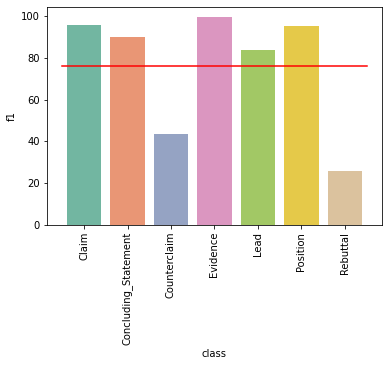

In [42]:
sns.barplot(y=f1_df.reset_index().loc[:6,'f1'],x=f1_df.index[:-1],palette='Set2')
plt.xticks(rotation=90)
locs,_=plt.xticks()
plt.plot([locs[0]-.5,locs[-1]+.5],[f1_df.loc['Total','f1'],f1_df.loc['Total','f1']],c='r');

In [43]:
# Full report
f1_df[['FP','FN','TP','support']]=f1_df[['FP','FN','TP','support']].applymap('{:.0f}'.format)
f1_df['f1_weighted']=f1_df['f1_weighted'].map('{:.2f}%'.format)
f1_df['f1']=f1_df['f1'].map('{:.2f}%'.format)

f1_df

,FP,FN,TP,f1,support,f1_weighted
class,,,,,,
Claim,79,49,1570,96.08%,3412,27.34%
Concluding_Statement,214,27,1106,90.18%,1346,10.12%
Counterclaim,162,202,141,43.65%,542,1.97%
Evidence,25,0,2400,99.48%,3792,31.46%
Lead,249,50,774,83.81%,963,6.73%
Position,23,68,955,95.45%,1535,12.22%
Rebuttal,128,199,57,25.85%,402,0.87%
Total,880,595,7003,76.36%,11992,90.70%


#### Confusion Matrix

In [44]:
def show_confusion_matrix(y_true,y_pred):

    reversed_mapping = {
                        0: 'Lead',
                        1: 'Position',
                        2: 'Evidence',
                        3: 'Claim',
                        4: 'Concluding_Statement',
                        5: 'Counterclaim',
                        6: 'Rebuttal',
                        7: 'Lead',
                        8: 'Position',
                        9: 'Evidence',
                        10: 'Claim',
                        11: 'Concluding_Statement',
                        12: 'Counterclaim',
                        13: 'Rebuttal',
                        14: 'O',
                        15: 'PAD'}
    
    y_true_flat = [reversed_mapping[y] for y in y_true.flatten()]
    y_pred_flat = [reversed_mapping[y] for y in y_pred.flatten()]
    
    LABELS = ['Lead','Position','Claim','Counterclaim','Rebuttal','Evidence','Concluding_Statement','O','PAD']

    cfn = confusion_matrix(y_true_flat,y_pred_flat,labels=LABELS)
    
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.title('Confusion Matrix',size=18,pad=20)
    sns.heatmap(cfn/np.sum(cfn,axis=0)*100,cmap='Blues',annot = True,fmt='.2f',annot_kws={'size':10},ax=ax);
    plt.xticks(np.arange(len(LABELS))+.5,LABELS,rotation = 90,size=12);
    plt.yticks(np.arange(len(LABELS))+.5,LABELS,rotation = 0,size=12);
    plt.xlabel('PREDICTED',size=16);
    plt.ylabel('ACTUAL',size=16);
    for t in ax.texts: t.set_text(t.get_text() + " %")
    
    plt.show()

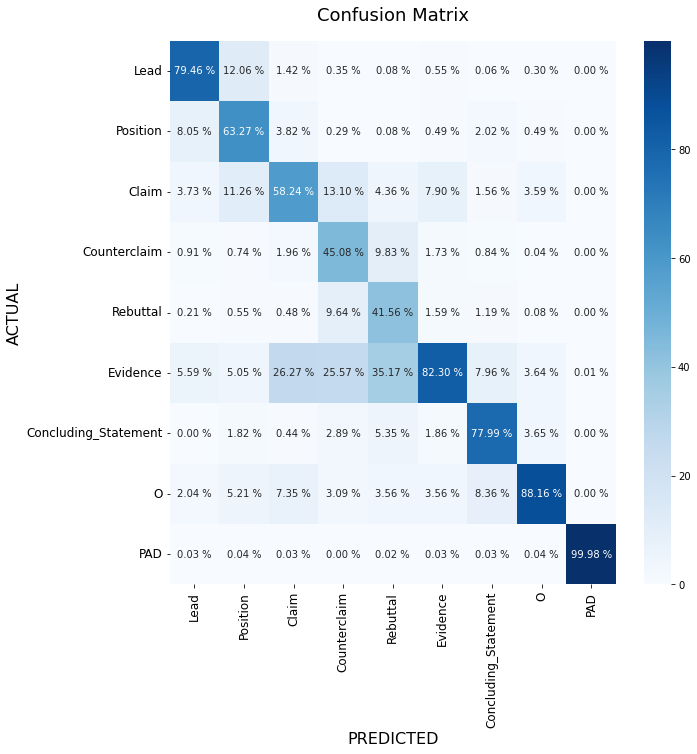

In [45]:
show_confusion_matrix(y_true,y_pred)